# Example 2: Company Counts by Year

This notebook loads the provided CSV and displays the count of unique companies by year created (inferred from the dataset's date column).


In [1]:
# Setup import path and loader
import sys, os
sys.path.append("../src")

from data_loader import load_data

In [2]:
# Load the dataset by filename
FILENAME = "North America Company Name Merge by DataDate-GVKEY-IID.csv"
df = load_data(filename=FILENAME)
print(df.shape)
df.head()


Loading data from: /Users/kevin/Coding Projects/Asset-Management-Hackathon-2025/data/North America Company Name Merge by DataDate-GVKEY-IID.csv
(4438944, 7)


,gvkey,datadate,iid,tic,cusip,conm,cik
0,1003,2005-01-31,01,ANTQ,000354100,A.A. IMPORTING CO INC,730052.0
1,1004,2005-01-31,01,AIR,000361105,AAR CORP,1750.0
2,1009,2005-01-31,01,ABSI.1,000781104,ABS INDUSTRIES INC,313368.0
3,1013,2005-01-31,01,ADCT.1,000886309,ADC TELECOMMUNICATIONS INC,61478.0
4,1019,2005-01-31,01,AFAP,001038108,AFA PROTECTIVE SYSTEMS INC,2668.0


In [3]:
# Normalize date column and compute year
import pandas as pd

# Try common date column names; adjust if needed
possible_date_cols = [
    "date", "Date", "DATA_DATE", "DataDate", "data_date", "datadate", "DataDate-GVKEY-IID", "DataDate_GVKEY_IID"
]

date_col = None
for col in possible_date_cols:
    if col in df.columns:
        date_col = col
        break

if date_col is None:
    # Fallback: try to auto-detect first datetime-like column
    for col in df.columns:
        try:
            pd.to_datetime(df[col])
            date_col = col
            break
        except Exception:
            pass

if date_col is None:
    raise ValueError("Could not find a date column; please update possible_date_cols.")

# Parse to datetime and extract year
s = pd.to_datetime(df[date_col], errors="coerce")
df = df.assign(_year=s.dt.year)

print(f"Using date column: {date_col}")
df[[date_col, "_year"]].head()


Using date column: datadate


,datadate,_year
0,2005-01-31,2005
1,2005-01-31,2005
2,2005-01-31,2005
3,2005-01-31,2005
4,2005-01-31,2005


In [4]:
# Determine company identity columns and count per year
# Prefer GVKEY+IID if available, else fall back to a company name column
company_id_cols_priority = [
    ["GVKEY", "IID"],
    ["gvkey", "iid"],
    ["GVKEY_IID"],
    ["COMPANY_NAME"],
    ["CompanyName"],
    ["company_name"],
]

used_cols = None
for cols in company_id_cols_priority:
    if all(c in df.columns for c in cols):
        used_cols = cols
        break

if used_cols is None:
    # Fallback: use first non-date string column as identity
    used_cols = [next((c for c in df.select_dtypes(include=["object", "string"]).columns if c != date_col), None)]

if used_cols[0] is None:
    raise ValueError("Could not determine company identity column(s). Please specify manually.")

# Build a key for counting unique companies per year
if len(used_cols) == 1:
    df = df.assign(_company_key=df[used_cols[0]].astype(str))
else:
    df = df.assign(_company_key=df[used_cols].astype(str).agg("-".join, axis=1))

counts = (
    df.dropna(subset=["_year", "_company_key"]).groupby("_year")["_company_key"].nunique().reset_index(name="num_companies")
)

print(f"Using company columns: {used_cols}")
counts.head(10)


Using company columns: ['gvkey', 'iid']


,_year,num_companies
0,2005,18768
1,2006,18960
2,2007,19282
3,2008,19151
4,2009,18836
5,2010,18522
6,2011,19613
7,2012,20265
8,2013,19945
9,2014,19919


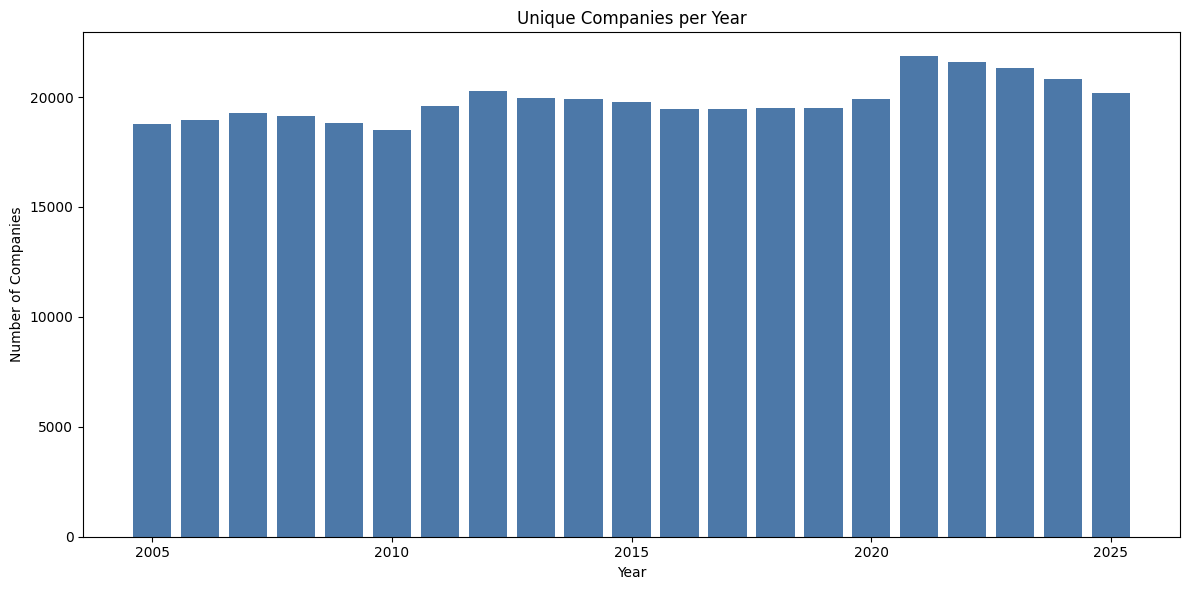

,_year,num_companies
11,2016,19445
12,2017,19463
13,2018,19481
14,2019,19496
15,2020,19921
16,2021,21851
17,2022,21605
18,2023,21313
19,2024,20832
20,2025,20195


In [5]:
# Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.bar(counts["_year"], counts["num_companies"], color="#4C78A8")
plt.title("Unique Companies per Year")
plt.xlabel("Year")
plt.ylabel("Number of Companies")
plt.tight_layout()
plt.show()

counts.sort_values("_year").tail(10)
